# Spectral Clustering Demo: Playing with Datasets

In [1]:
import numpy as np 
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt 
from spectral_clustering import SpectralClustering
from svd_spectral_clustering import SVDSpectralClustering

## Case 1: Example Dataset

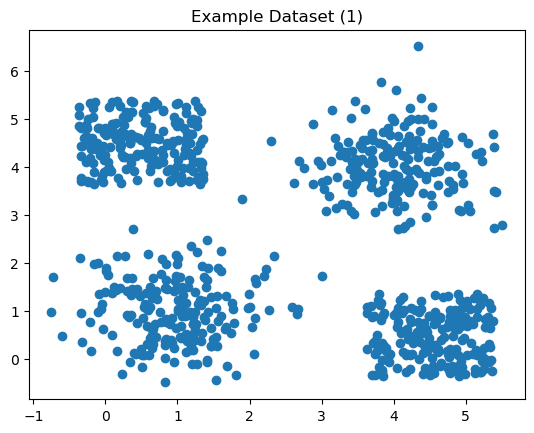

In [2]:
X_s, labels_s, = make_blobs(
    [200, 200],
    2,
    centers = [(4,4), (1, 1)],
    cluster_std=[0.65, 0.65],
    random_state=42
)

def make_square_blobs(n_samples, centers, side=1, random_state=None, jitter=0.0, weights=None):
    rng = np.random.default_rng(random_state) # rng to make the borders slightly perturbed
    k = len(centers)

    if weights is None:
        counts = np.full(k, n_samples // k)
        counts[:n_samples - counts.sum()] += 1
    else:
        weights = np.asarray(weights) / np.sum(weights)
        counts = rng.multinomial(n_samples, weights)

    half = side / 2
    X_list, y_list = [], []
    for i, (cx, cy) in enumerate(centers):
        pts = rng.uniform(-half, half, size=(counts[i], 2)) + (cx, cy)
        if jitter > 0:
            pts += rng.normal(scale=jitter, size=pts.shape)
        X_list.append(pts)
        y_list.append(np.full(counts[i], i))
    return np.vstack(X_list), np.concatenate(y_list)

X_squares, label_squares = make_square_blobs(400, [(0.5, 4.5), (4.5, 0.5)], side=1.75)

X = np.vstack((X_s, X_squares))
y = np.vstack((labels_s, label_squares+2))

plt.scatter(X[:, 0], X[:, 1])
plt.title("Example Dataset (1)")
plt.show()

In [3]:
# Now use the described clustering methods

sigma = 1.70
def normal_similarity(X, Y):
    return np.exp(np.linalg.norm(X-Y, 2) / (2*sigma)**2)

labels_1 = SpectralClustering(4, normal_similarity).fit_predict(X)
labels_2 = SVDSpectralClustering(4, 4, normal_similarity).fit_predict(X)

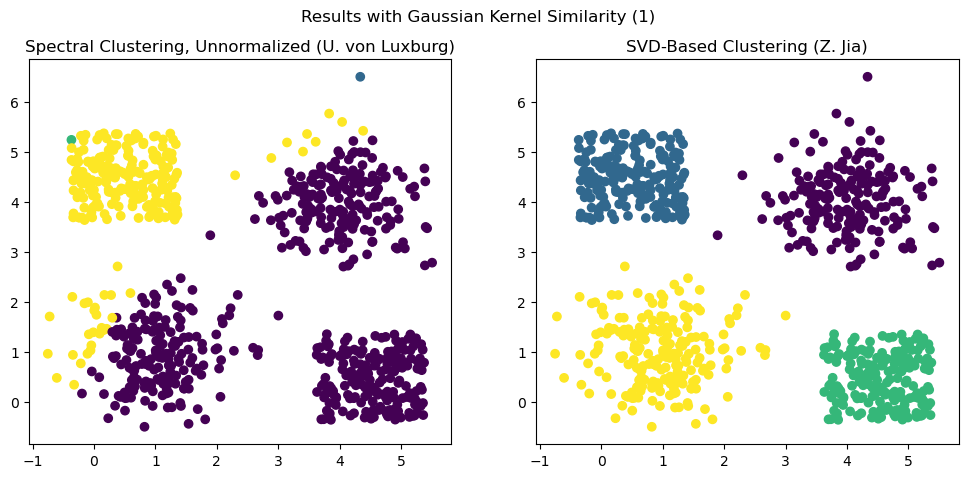

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].scatter(X[:, 0], X[:, 1], c=labels_1)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_2)

axes[0].set_title("Spectral Clustering, Unnormalized (U. von Luxburg)")
axes[1].set_title("SVD-Based Clustering (Z. Jia)")

plt.suptitle("Results with Gaussian Kernel Similarity (1)")
plt.show()

## Case 2: Non-Linearly Separable Toy Datasets

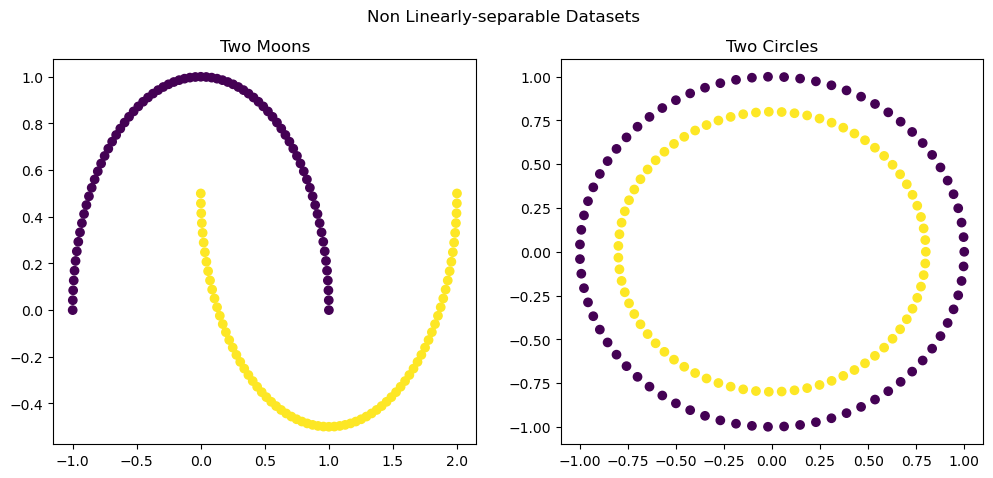

In [9]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles

fig, axes = plt.subplots(1, 2, figsize = (12, 5))

X1, y1 = make_moons(150)
axes[0].scatter(X1[:, 0], X1[:, 1], c=y1)
axes[0].set_title("Two Moons")

X2, y2 = make_circles(150)
axes[1].scatter(X2[:, 0], X2[:, 1], c=y2)
axes[1].set_title("Two Circles")

plt.suptitle("Non Linearly-separable Datasets")

plt.show()

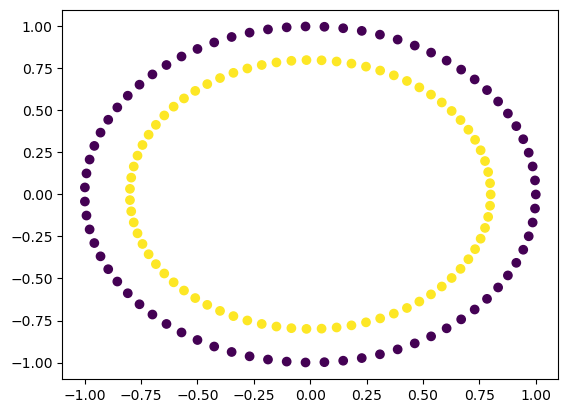

In [5]:
from sklearn.datasets import make_circles

X, y = make_circles(150)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [367]:
sigma = 1
def normal_similarity(X, Y):
    return np.exp(np.linalg.norm(X-Y, 2) / (2*sigma)**2)


In [368]:
labels_1 = SVDSpectralClustering(2, 2, normal_similarity).fit_predict(X)
labels_2 = SVDSpectralClustering(2, 1, normal_similarity).fit_predict(X)
labels_3 = SVDSpectralClustering(2, 3, normal_similarity).fit_predict(X)


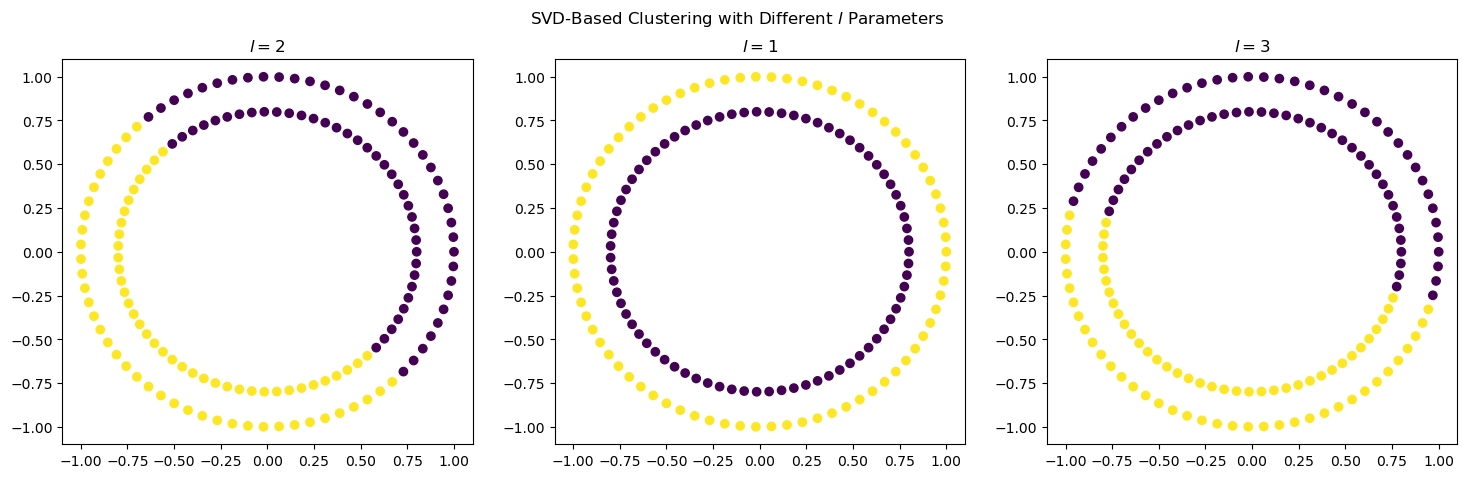

In [369]:
fig, axes = plt.subplots(1, 3, figsize = (18, 5))

axes[0].scatter(X[:, 0], X[:, 1], c=labels_1)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_2)
axes[2].scatter(X[:, 0], X[:, 1], c=labels_3)


axes[0].set_title("$l=2$")
axes[1].set_title("$l=1$")
axes[2].set_title("$l=3$")

plt.suptitle("SVD-Based Clustering with Different $l$ Parameters")

plt.show()

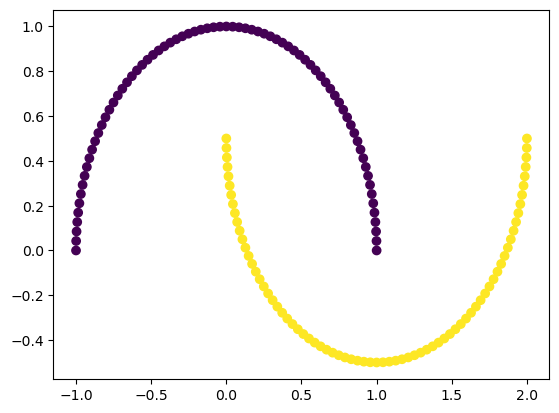

In [370]:
from sklearn.datasets import make_moons

X, y = make_moons(150)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

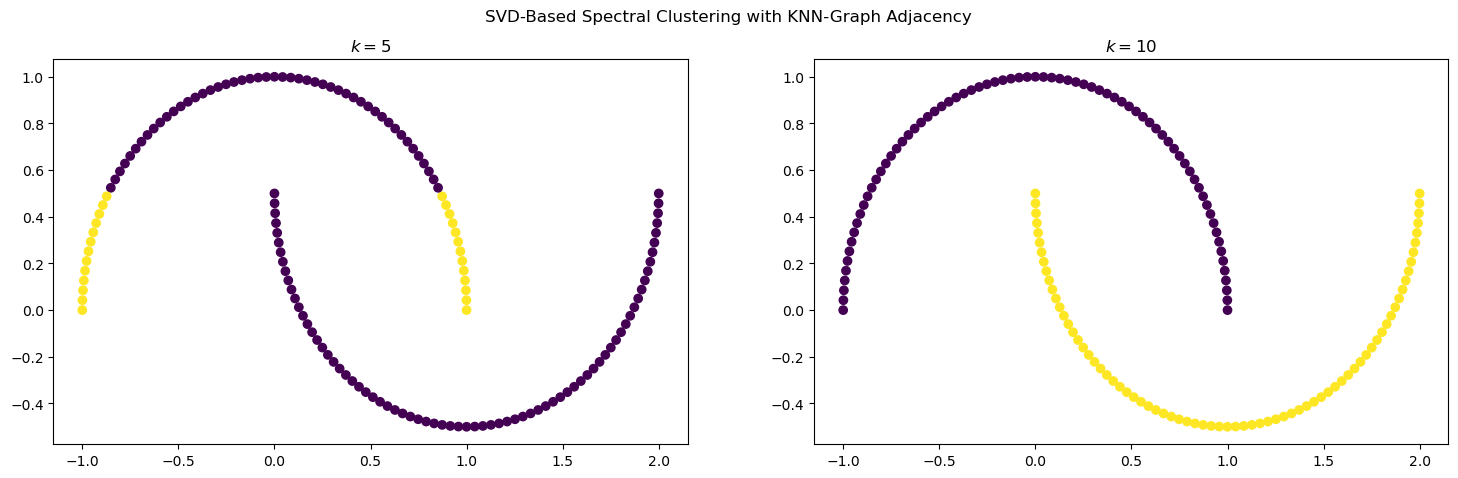

In [371]:
labels_1= SVDSpectralClustering(2, 2, None).fit_predict_kneighbors(X, 5)
labels_2 = SVDSpectralClustering(2, 2, None).fit_predict_kneighbors(X, 10)

fig, axes = plt.subplots(1, 2, figsize = (18, 5))

axes[0].scatter(X[:, 0], X[:, 1], c=labels_1)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_2)


axes[0].set_title("$k=5$")
axes[1].set_title("$k=10$")

plt.suptitle("SVD-Based Spectral Clustering with KNN-Graph Adjacency")
plt.show()

## Case 3: Deducing the Parameters by Studying the SVD

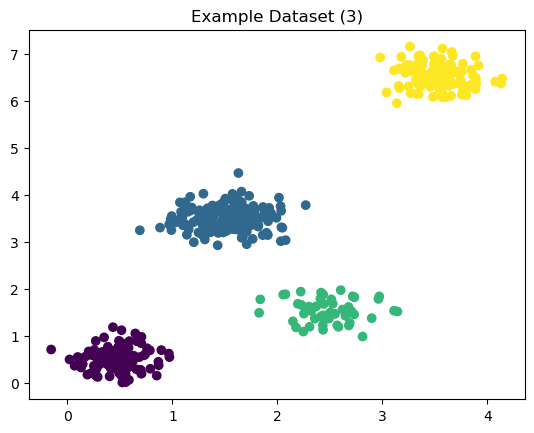

In [11]:
X, y, = make_blobs(
    [100, 200, 50, 120],
    2,
    centers=[(0.5, 0.5), (1.5, 3.5), (2.5, 1.5), (3.5, 6.5)],
    cluster_std=[0.25, 0.25, 0.25, 0.25],
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Example Dataset (3)")
plt.show()

In [12]:
sigma = 0.5
def normal_similarity(X, Y):
    return np.exp(np.linalg.norm(X-Y, 2) / (2*sigma)**2)

study = SVDSpectralClustering(0, 0, normal_similarity)
U, S, Vh = study.get_similarity_svd(X)

In [13]:
import pandas as pd

In [14]:
# Calculate S_k - S_(k+1), S_k - 2 S_(k+1) + S_(k+2) and \sum_{n <= k} S_n / \sum_n S_n and stack the results into a matrix

N_MAX = 6

col_1 = S[: N_MAX] - S[1: N_MAX+1]
col_2 = S[: N_MAX] - 2 * S[1: N_MAX+1] + S[2: N_MAX+2]
col_3 = np.array([np.sum(S[ : k]) / np.sum(S) for k in range(0, N_MAX)])

info = np.hstack((col_1, col_2, col_3)).reshape(3, N_MAX)

df = pd.DataFrame(info, index=["Equation 1", "Equation 2", "Equation 3"], columns=list(range(1, N_MAX+1)))

df = df.T


In [15]:
df

,Equation 1,Equation 2,Equation 3
1,951.505869,-104248.833383,0.000000
2,105200.339252,104848.569360,0.494318
3,351.769892,-493.714633,0.984268
4,845.484526,765.569084,0.991174
5,79.915441,-96.767627,0.996465
6,176.683069,164.619531,0.997873


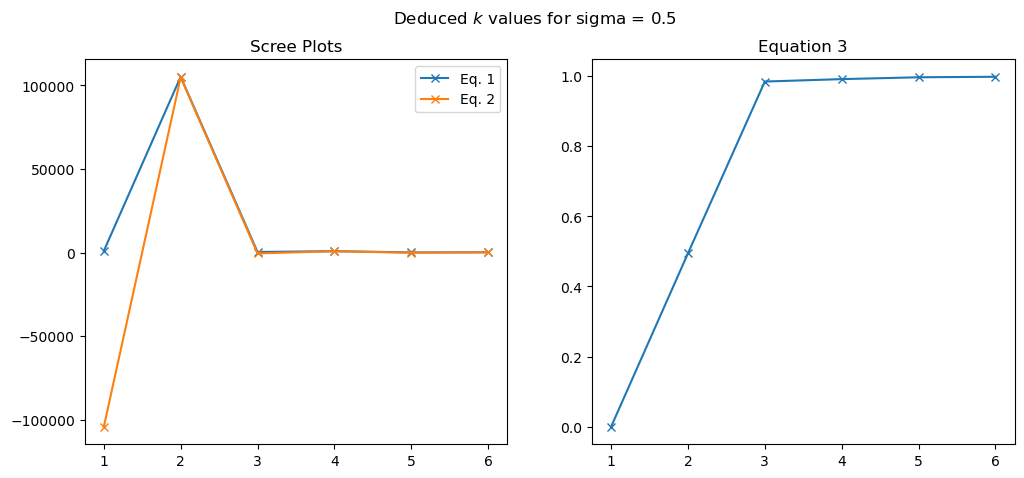

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(df.loc[:, 'Equation 1'], marker="x", label="Eq. 1")
axes[0].plot(df.loc[:, 'Equation 2'], marker="x", label="Eq. 2")

axes[0].set_title("Scree Plots")
axes[0].legend()

axes[1].plot(df.iloc[:, 2], marker='x')
axes[1].set_title("Equation 3")

plt.suptitle("Deduced $k$ values for sigma = 0.5")

plt.show()

Inconsistent results: sigma value is inappropriate, re-tune it to 1

In [23]:
sigma = 1
def normal_similarity(X, Y):
    return np.exp(np.linalg.norm(X-Y, 2) / (2*sigma)**2)

study = SVDSpectralClustering(0, 0, normal_similarity)
U, S, Vh = study.get_similarity_svd(X)

In [24]:
# Calculate S_k - S_(k+1), S_k - 2 S_(k+1) + S_(k+2) and \sum_{n <= k} S_n / \sum_n S_n and stack the results into a matrix

N_MAX = 6

col_1 = S[: N_MAX] - S[1: N_MAX+1]
col_2 = S[: N_MAX] - 2 * S[1: N_MAX+1] + S[2: N_MAX+2]
col_3 = np.array([np.sum(S[ : k]) / np.sum(S) for k in range(0, N_MAX)])

info = np.hstack((col_1, col_2, col_3)).reshape(3, N_MAX)

df = pd.DataFrame(info, index=["Equation 1", "Equation 2", "Equation 3"], columns=list(range(1, N_MAX+1)))

df = df.T


In [25]:
df

,Equation 1,Equation 2,Equation 3
1,631.578044,209.478875,0.000000
2,422.099170,372.074015,0.630368
3,50.025154,22.751371,0.910363
4,27.273783,26.229743,0.956195
5,1.044040,0.390150,0.974276
6,0.653890,0.094331,0.977226


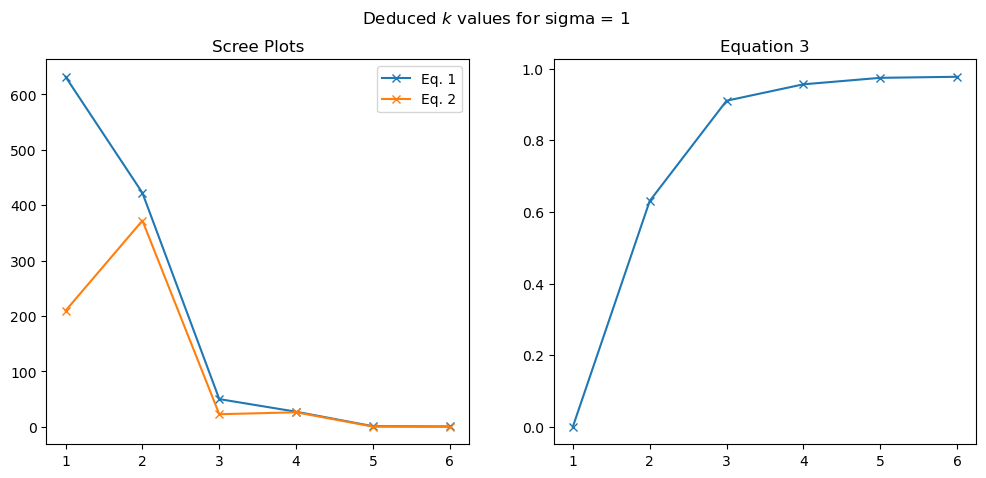

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(df.loc[:, 'Equation 1'], marker="x", label="Eq. 1")
axes[0].plot(df.loc[:, 'Equation 2'], marker="x", label="Eq. 2")

axes[0].set_title("Scree Plots")
axes[0].legend()

axes[1].plot(df.iloc[:, 2], marker='x')
axes[1].set_title("Equation 3")

plt.suptitle("Deduced $k$ values for sigma = 1")

plt.show()

By using the elbow method, we easily deduce that the optimal value is $k=4$ 

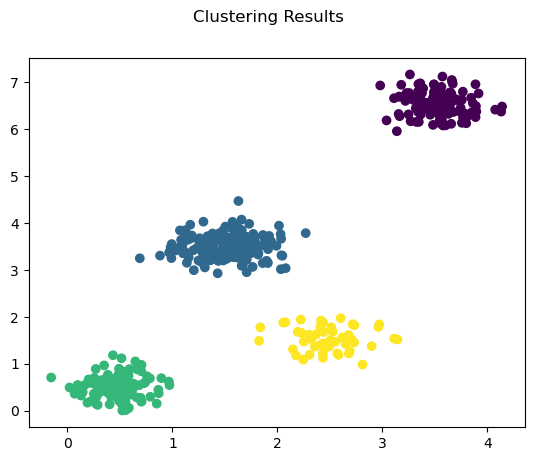

In [30]:
cluster = SVDSpectralClustering(4, 4, normal_similarity)
labels = cluster.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.suptitle("Clustering Results")
plt.show()